In [2]:
%load_ext autoreload
%autoreload 2
    
import os
import cv2
import sys
import copy
import json
import random
import rasterio
import numpy as np
import tifffile as tiff
from skimage.transform import rescale, resize

import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model, model_from_json

from keras.optimizers import SGD, Adam, RMSprop
from keras.backend import categorical_crossentropy, binary_crossentropy
from segmentation_models import Unet, FPN

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
sys.path.insert(0, '../')
from height_model_scripts.loss_functions import rmse
from height_model_scripts.metrics import F1_metric, RMSE, MAE, R2, MBE
from height_model_scripts.height_model_scripts import Generator
from height_model_scripts.save_pred import save_pred, tif2geojson

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Split on test, train, validation

In [4]:
train_img_list = []
test_img_list = []
val_img_list = []

train_list_split = ['0_0', '0_1', '0_2',
               '1_0', '1_2',
               '2_0', '2_1', '2_3', '2_4', '2_5',
               '3_1', '3_2', '3_3',
               '4_1', '4_3', '4_4', '4_5',
               '5_1', '5_2', '5_3', '5_4',
               '6_0', '6_1', '6_2', '6_4',
               '7_0', '7_1', '7_2', '7_3', '7_4']
val_list_split = ['1_1', '2_2', '4_2', '6_3']

# krasnoborsk
for folder in os.listdir('/home/user/data/krasnoborsk/world_view/'):
    if 'tif' in folder or 'xml' in folder or folder == 'lines':
        continue
    for file_name in os.listdir('/home/user/data/krasnoborsk/world_view/{}'.format(folder)):
        tmp_ind = file_name.split('_')[0]+'_'+file_name.split('_')[1]
        if tmp_ind in train_list_split and '/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind) not in train_img_list:
            train_img_list += ['/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind)]
        elif tmp_ind in val_list_split and '/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind) not in val_img_list \
            and folder == '0':
            val_img_list += ['/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind)]

# Novoshinsk
dse_pathechs = ['0_0', '0_1', '0_2',
               '1_0', '1_1', '1_2', '1_3',
               '2_0', '2_1', '2_2', '2_3', '2_4', 
               '3_0', '3_1', '3_2', '3_3', '3_4',
               '4_0', '4_1', '4_3', '4_4',
               '5_3', '5_4',
               '6_2', '6_3', '6_4',
               '7_2', '7_3', '7_4',
               '8_2', '8_3', '8_4']

for file_ind in [0, 1, 7, 9]: # 2 winter
    for patch_ind in dse_pathechs:
        i, j = patch_ind.split('_')
        if patch_ind +'_channel_0.tif' not in os.listdir('/home/user/data/krasnoborsk/Novoshinsk/{}'.format(file_ind)) \
            or patch_ind +'_class_606.tif' not in os.listdir('/home/user/data/krasnoborsk/Novoshinsk/{}'.format(file_ind)):
            continue
        if patch_ind in ['1_1', '2_2', '4_4']:
            test_img_list += ['/home/user/data/krasnoborsk/Novoshinsk/{}/{}'.format(file_ind, patch_ind)]
        else:
            train_img_list += ['/home/user/data/krasnoborsk/Novoshinsk/{}/{}'.format(file_ind, patch_ind)]


## New model

In [7]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(0, '../')
from height_model_scripts.height_model_scripts import Generator

batch_size=20 
num_channels=5

generator = Generator(train_img_list, val_img_list, batch_size, num_channels)

generator.augm = False              # just geometric rotation is applied
generator.sharpen_flag = True     # flag to switch pansharpaning
generator.forest_mask = True       # add forest mask if it is provided
generator.clip_value = 40.         # the greatest height value 
generator.lidar_coef = 5           # parameter for height resolution downsampling

generator.arctic_dem = True
generator.arctic_stat = {'min':125, 'max':250}

generator.lidar_coef = 5           # parameter for height resolution downsampling
generator.lidar_resolution = 1     # resolution of height data
generator.target_resolution = 1    # target resolution both for height and imagery
generator.classifier_mode='classification'
generator.channels_list = ['channel_0.tif', 'channel_1.tif', 'channel_2.tif', 'channel_3.tif']

In [9]:
generator.write_gdalinfo_file()

Text(0.5,1,'0-1')

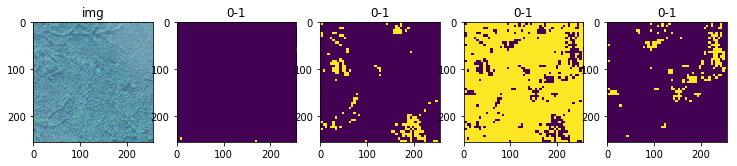

In [10]:
# check output
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[0])

fig = plt.figure(figsize = (15,15))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('0-1')
a = fig.add_subplot(1, 6, 3)
imgplot = plt.imshow(mask_tmp[:,:,1])
a.set_title('0-1')
a = fig.add_subplot(1, 6, 4)
imgplot = plt.imshow(mask_tmp[:,:,2])
a.set_title('0-1')
a = fig.add_subplot(1, 6, 5)
imgplot = plt.imshow(mask_tmp[:,:,3])
a.set_title('0-1')

Text(0.5,1,'0-1')

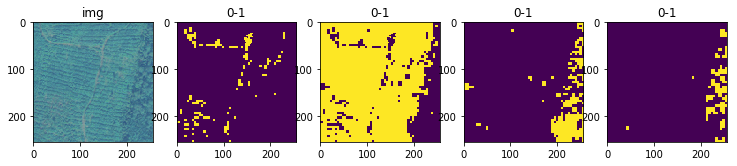

In [11]:
# check output
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[0])

fig = plt.figure(figsize = (15,15))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('0-1')
a = fig.add_subplot(1, 6, 3)
imgplot = plt.imshow(mask_tmp[:,:,1])
a.set_title('0-1')
a = fig.add_subplot(1, 6, 4)
imgplot = plt.imshow(mask_tmp[:,:,2])
a.set_title('0-1')
a = fig.add_subplot(1, 6, 5)
imgplot = plt.imshow(mask_tmp[:,:,3])
a.set_title('0-1')

In [5]:
generator.write_gdalinfo_file()

In [6]:
generator.data_gdal

{'/home/user/data/krasnoborsk/world_view/4/height_1_0.tif': {'dx': 1.8943136583e-05,
  'dy': -8.869628916e-06,
  'x0': 45.67984678736104,
  'y0': 61.466215670458425,
  'size_x': 1918,
  'size_y': 2498},
 '/home/user/data/krasnoborsk/world_view/4/1_0_pan.tif': {'dx': 4.266978081e-06,
  'dy': -4.266978081e-06,
  'x0': 45.679864864207694,
  'y0': 61.46621609715774,
  'size_x': 8511,
  'size_y': 5192},
 '/home/user/data/krasnoborsk/world_view/4/1_0_class_606.tif': {'dx': 1.7085878548e-05,
  'dy': -1.7085878548e-05,
  'x0': 45.68227469685591,
  'y0': 61.46621788701401,
  'size_x': 1984,
  'size_y': 1297},
 '/home/user/data/krasnoborsk/world_view/4/1_0_channel_0.tif': {'dx': 1.7085878548e-05,
  'dy': -1.7085878548e-05,
  'x0': 45.6798655879806,
  'y0': 61.46621788701401,
  'size_x': 2125,
  'size_y': 1297},
 '/home/user/data/krasnoborsk/world_view/4/1_0_channel_1.tif': {'dx': 1.7085878548e-05,
  'dy': -1.7085878548e-05,
  'x0': 45.6798655879806,
  'y0': 61.46621788701401,
  'size_x': 2125,
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'lidar')

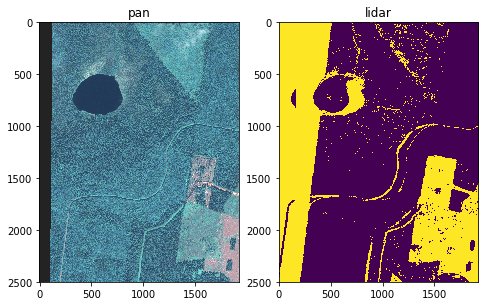

In [8]:
# check output
generator.augm = False
generator.full_img = True
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[2])
generator.full_img = False
generator.augm = True   

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])# * (mask_pan>130))
a.set_title('pan')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

In [12]:
from height_model_scripts.loss_functions import weighted_categorical_crossentropy

weights_list = [2.57, 3.32, 1.0, 1.84]

model = Unet(backbone_name='inceptionresnetv2', input_shape=(None, None, num_channels), 
                  encoder_weights=None, activation='sigmoid', classes=4)
loss =  weighted_categorical_crossentropy(weights_list, generator.batch_size, generator.IMG_ROW, generator.IMG_COL)
opt = RMSprop(lr=0.001)
metrics=[loss]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

/opt/conda/lib/python3.6/site-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 5 input channels.
  str(input_shape[-1]) + ' input channels.')


In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

model_name = 'cl_height_model'
save_dir = '/home/user/data/example/data/Forestry_inventory/Height_model_paper/'

# csv logger
log_filename = os.path.join(save_dir, '{}.csv'.format(model_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=5,min_lr=1e-9,verbose=1,mode='min'), #pat 7
    ModelCheckpoint(save_dir + '{}.h5'.format(model_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}.hdf5'.format(model_name),save_best_only=True,verbose=1, save_weights_only=True),
    csv_logger
]

In [ ]:
history=model.fit_generator(generator.train_gen(),epochs=25, 
                           steps_per_epoch=200,
                           validation_data=generator.val_gen(),  
                           callbacks=callbacks, validation_steps=100)

Epoch 1/25
186/200 [==========================>...] - ETA: 9s - loss: 2.0798 - loss_1: 2.0798 

In [21]:
model.load_weights(save_dir+"{}.h5".format(model_name)) 

In [29]:
generator.augm  = False
prediction, full_mask = generator.pred_img(model)

In [23]:
pred_1=prediction[0]
maskarr_1=full_mask[0]
print('rmse', round(np.sqrt(np.sum(np.square(pred_1*generator.clip_value - maskarr_1*generator.clip_value*np.where(pred_1==0, 0, 1)))/np.sum(np.where(pred_1==0, 0, 1))), 3))
print('mae', round(np.sum(np.abs(pred_1*generator.clip_value - maskarr_1*generator.clip_value*np.where(pred_1==0, 0, 1)))/np.sum(np.where(pred_1==0, 0, 1)), 3))

rmse 5.352
mae 3.643


In [35]:
lidar_coef = 2.5
mask_0 = full_mask
mask_0 = np.expand_dims(cv2.resize(mask_0[0], (int(mask_0.shape[0]/lidar_coef), int(mask_0.shape[1]/lidar_coef)), 
                                   interpolation=cv2.INTER_AREA), 0)
mask_0 = np.expand_dims(cv2.resize(mask_0[0], (mask_0.shape[0], mask_0.shape[1]), interpolation=cv2.INTER_NEAREST), 0)

pred_1=prediction[0]
print('rmse', round(np.sqrt(np.sum(np.square(pred_1*generator.clip_value - maskarr_1*generator.clip_value*np.where(pred_1==0, 0, 1)))/np.sum(np.where(pred_1==0, 0, 1))), 3))
print('mae', round(np.sum(np.abs(pred_1*generator.clip_value - maskarr_1*generator.clip_value*np.where(pred_1==0, 0, 1)))/np.sum(np.where(pred_1==0, 0, 1)), 3))

rmse 4.591
mae 2.921


In [49]:
# serialize model to JSON without height
model_json = model.to_json()
model_name = 'tmp'
with open(save_dir+"{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_dir+"{}.h5".format(model_name))
print("Saved model to disk")

Saved model to disk


In [50]:
model_name = 'cl_height_model'
model.load_weights(save_dir+"{}.h5".format(model_name)) 

# Exp

In [5]:
val_img_list = val_img_list[0]

In [6]:
from keras.models import model_from_json
# serialize model to JSON without height
model_name = 'height_model_2m'
json_file = open(save_dir+"{}.json".format(model_name), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(save_dir+"{}.h5".format(model_name)) 

In [7]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(0, '../')
from height_model_scripts.height_model_scripts import Generator

batch_size=20 
num_channels=4

generator = Generator(train_img_list, val_img_list, batch_size, num_channels)

generator.augm = False              # just geometric rotation is applied
generator.sharpen_flag = True     # flag to switch pansharpaning
generator.forest_mask = True       # add forest mask if it is provided
generator.clip_value = 40.         # the greatest height value 
generator.lidar_coef = 5           # parameter for height resolution downsampling
generator.lidar_resolution = 1     # resolution of height data
generator.target_resolution = 1    # target resolution both for height and imagery
generator.classifier_mode = 'classification'
generator.channels_list = ['channel_0.tif', 'channel_1.tif', 'channel_2.tif', 'channel_3.tif']

In [6]:
generator.channels_list

['channel_0.tif', 'channel_1.tif', 'channel_2.tif', 'channel_3.tif']

In [5]:
generator.write_gdalinfo_file()

In [8]:
recon, mask = generator.pred_img(model, val_img_list[0])

In [6]:
generator.data_gdal

{'/home/user/data/krasnoborsk/world_view/4/1_0_channel_0.tif': {'dx': 1.7085878548e-05,
  'dy': -1.7085878548e-05,
  'x0': 45.6798655879806,
  'y0': 61.46621788701401,
  'size_x': 2125,
  'size_y': 1297},
 '/home/user/data/krasnoborsk/world_view/4/1_0_channel_1.tif': {'dx': 1.7085878548e-05,
  'dy': -1.7085878548e-05,
  'x0': 45.6798655879806,
  'y0': 61.46621788701401,
  'size_x': 2125,
  'size_y': 1297},
 '/home/user/data/krasnoborsk/world_view/4/1_0_channel_2.tif': {'dx': 1.7085878548e-05,
  'dy': -1.7085878548e-05,
  'x0': 45.6798655879806,
  'y0': 61.46621788701401,
  'size_x': 2125,
  'size_y': 1297},
 '/home/user/data/krasnoborsk/world_view/4/1_0_channel_3.tif': {'dx': 1.7085878548e-05,
  'dy': -1.7085878548e-05,
  'x0': 45.6798655879806,
  'y0': 61.46621788701401,
  'size_x': 2125,
  'size_y': 1297},
 '/home/user/data/krasnoborsk/world_view/4/height_1_0.tif': {'dx': 1.8943136583e-05,
  'dy': -8.869628916e-06,
  'x0': 45.67984678736104,
  'y0': 61.466215670458425,
  'size_x': 19

In [11]:
a = [1, 2, 3] + [4]
a

[1, 2, 3, 4]

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f440b664f98>)

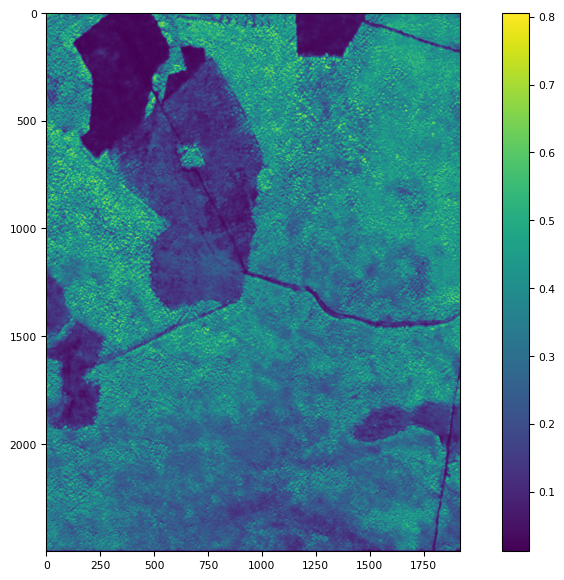

In [9]:
tiff.imshow(recon)

In [43]:
os.listdir('/home/user/data/gornozavodsk_img/world_view/')

['12', '4', '7', '10', '3', '5', '9', '8', '11', '6', '0']

In [23]:
def metric_4cl(model, num_cl = 4):
    
    TP = np.zeros((num_cl), dtype=int)
    TN = np.zeros((num_cl), dtype=int)
    FN = np.zeros((num_cl), dtype=int)
    FP = np.zeros((num_cl), dtype=int)
    
    maskarr=[]
    forestarr=[]
    pred=[]
    imgarr=[]
    
    precision = np.zeros((num_cl))
    recall = np.zeros((num_cl))
    accuracy = np.zeros((num_cl))
    f1_cl = np.zeros((num_cl))
    IMG_ROW=IMG_COL=256
    for id_elem in range(len(val_img_list)): #val_img_list
        
        img,mask=generator.get_img_mask_array(val_img_list[id_elem]) #val_img_list
        size_x, size_y, _ = img.shape
        for i in range(0, int(size_x / IMG_ROW)):
            for j in range(0, int(size_y / IMG_COL)):
                imgarr.append(img[i*IMG_ROW:i*IMG_ROW + IMG_ROW, j*IMG_COL:j*IMG_COL + IMG_COL])
                maskarr.append(mask[i*IMG_ROW:i*IMG_ROW + IMG_ROW, j*IMG_COL:j*IMG_COL + IMG_COL])
                #forestarr.append(mask_forest[i*IMG_ROW:i*IMG_ROW + IMG_ROW, j*IMG_COL:j*IMG_COL + IMG_COL])
    imgarr = np.asarray(imgarr)
    maskarr = np.asarray(maskarr)
    pred = model.predict(imgarr)
    #return maskarr,pred
    
    for cl in range(num_cl):
        gt = np.where(maskarr[:,:,:,cl] == 1, 1, 0)
        pr_cl = np.sum(maskarr, axis=3)*np.where(np.argmax(pred, axis=3)==cl, 1, 0)
        TP[cl] += np.sum(pr_cl * gt)
        FP[cl] += np.sum(pr_cl * np.where(gt==0, 1, 0)*np.sum(maskarr, axis=3))
        FN[cl] += np.sum(np.where(pr_cl==0, 1, 0) * gt )
        TN[cl] += np.sum(np.where(pr_cl==0, 1, 0) * np.where(gt==0, 1, 0)*np.sum(maskarr, axis=3))
    #print(FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN) 
    f1_cl = 2*((precision*recall)/(precision+recall))

    classes = ['0', '1', '2', '3']
    for i in range(num_cl):
        print(classes[i], ': precision ', round(precision[i], 3), ' recall ', round(recall[i], 3), ' f1 ', round(f1_cl[i], 3))
        print(' ')

In [52]:
(0.595+0.665+0.839+0.561)/4, (0.796+0.489+0.781+0.628)/4

(0.665, 0.6735000000000001)

In [24]:
metric_4cl(model)

0 : precision  0.795  recall  0.475  f1  0.595
 
1 : precision  0.556  recall  0.825  f1  0.665
 
2 : precision  0.79  recall  0.894  f1  0.839
 
3 : precision  0.779  recall  0.439  f1  0.561
 


In [51]:
metric_4cl(model)

0 : precision  0.857  recall  0.743  f1  0.796
 
1 : precision  0.416  recall  0.594  f1  0.489
 
2 : precision  0.863  recall  0.713  f1  0.781
 
3 : precision  0.526  recall  0.779  f1  0.628
 


***
***

## Evaluation

In [16]:
for img, mask in generator.val_gen():
    break
pred = model.predict(img)

In [ ]:
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[0])

fig = plt.figure(figsize = (15,15))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('0-1')
a = fig.add_subplot(1, 6, 3)
imgplot = plt.imshow(mask_tmp[:,:,1])
a.set_title('0-1')
a = fig.add_subplot(1, 6, 4)
imgplot = plt.imshow(mask_tmp[:,:,2])
a.set_title('0-1')
a = fig.add_subplot(1, 6, 5)
imgplot = plt.imshow(mask_tmp[:,:,3])
a.set_title('0-1')

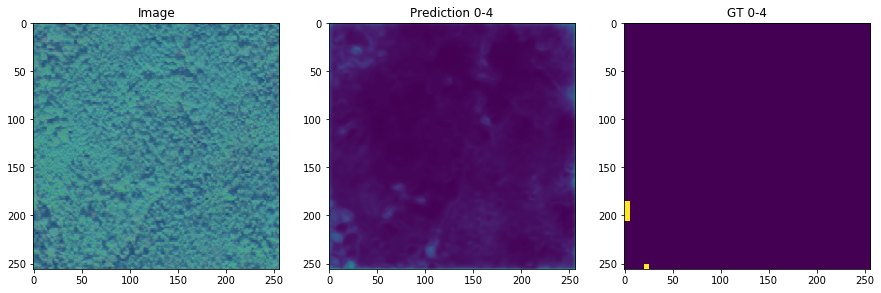

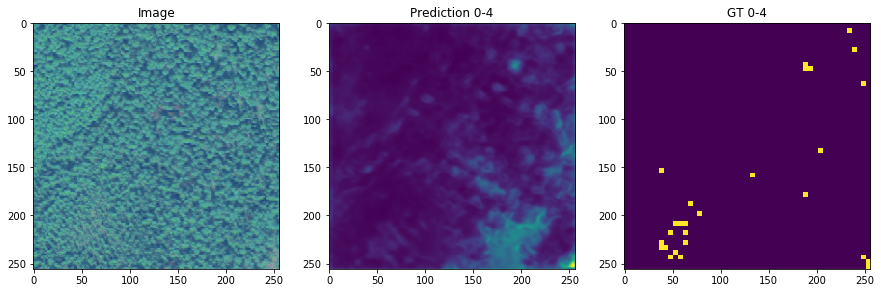

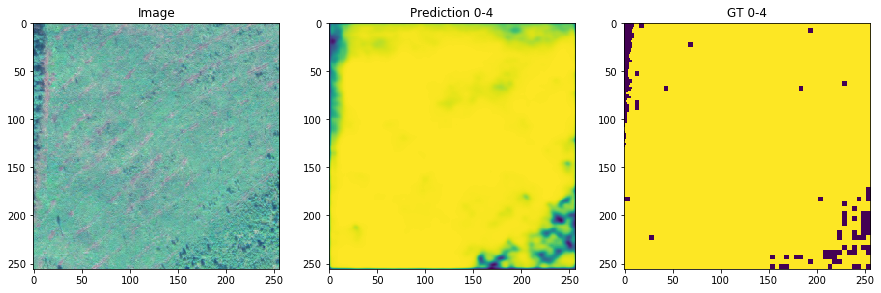

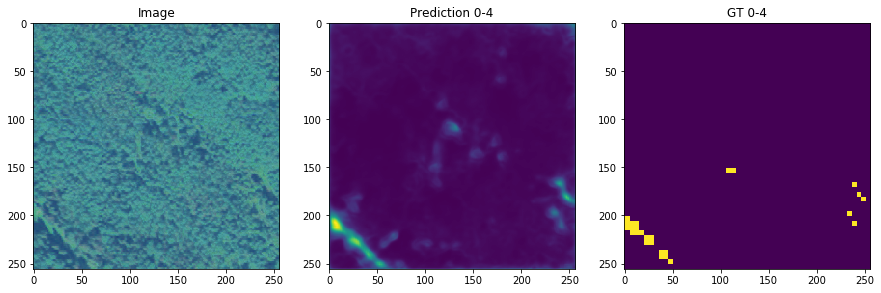

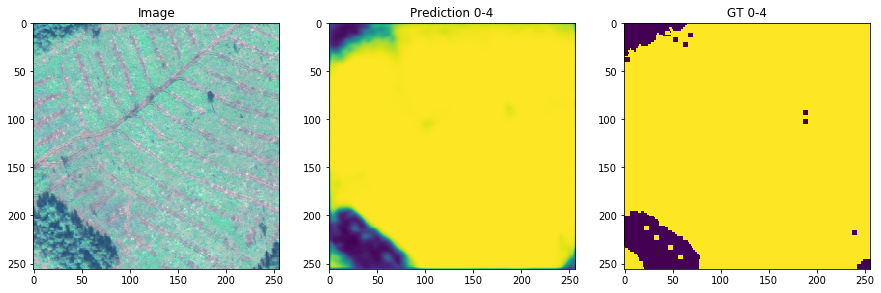

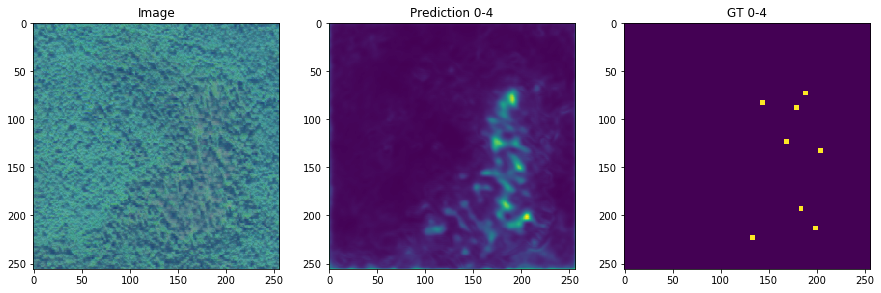

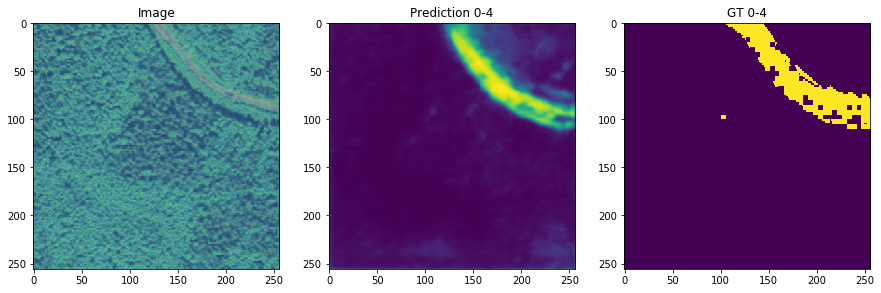

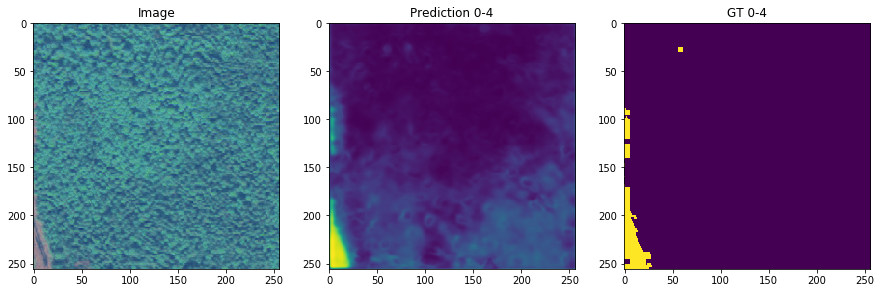

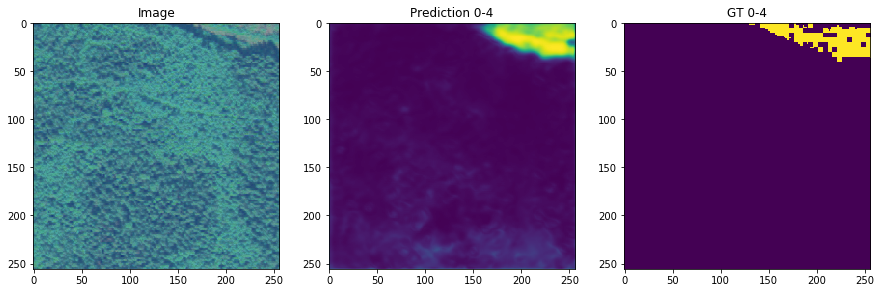

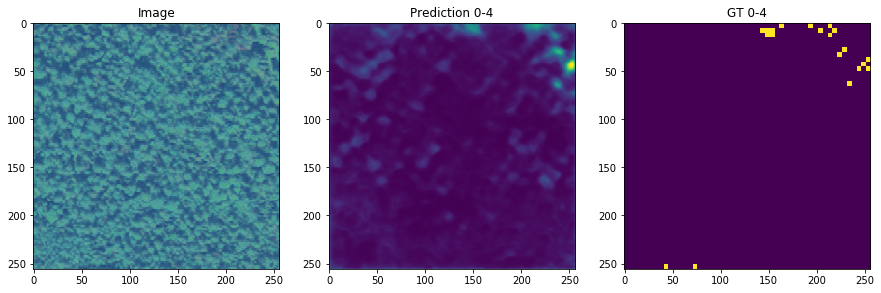

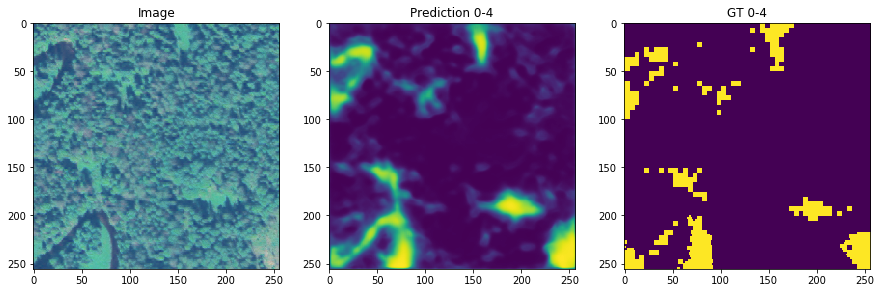

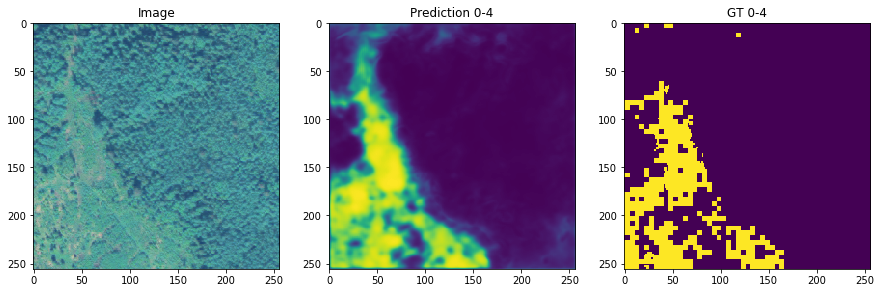

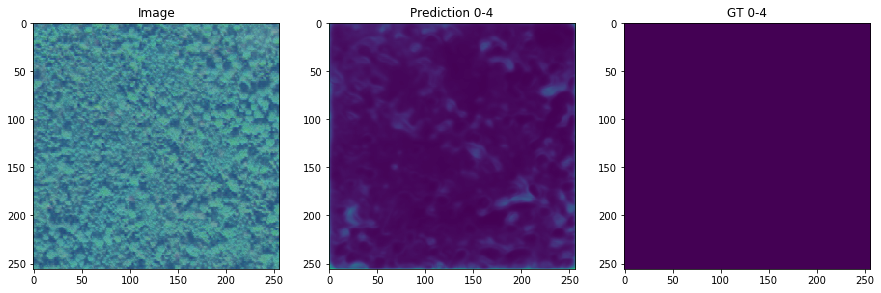

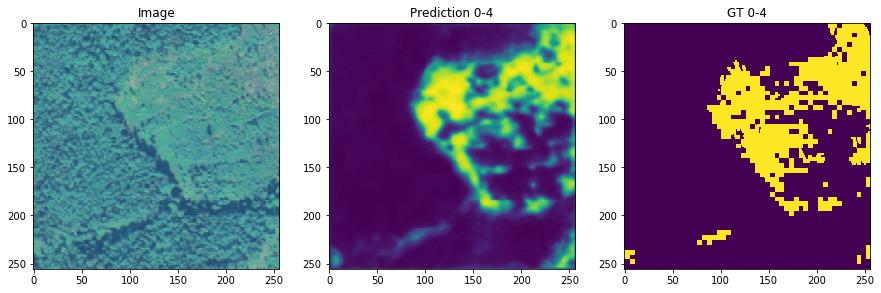

In [17]:
for num in range(1, 15):
    fig = plt.figure(figsize=(15, 15))
    
    a = fig.add_subplot(1, 3, 1)
    a.set_title('Image')
    imgplot = plt.imshow(img[num,:,:,:3])
    
    cl=0
    a = fig.add_subplot(1, 3, 2)
    a.set_title('Prediction 0-4')
    imgplot = plt.imshow(pred[num, :, :,0]) #.imshow(pred[num,:,:,cl]>0.5) 
    a = fig.add_subplot(1, 3, 3)
    a.set_title('GT 0-4')
    imgplot = plt.imshow(mask[num, :, :,0])

In [30]:
generator.train_img_list[8]

'/home/user/data/krasnoborsk/world_view/4/3_2'

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f8375151710>)

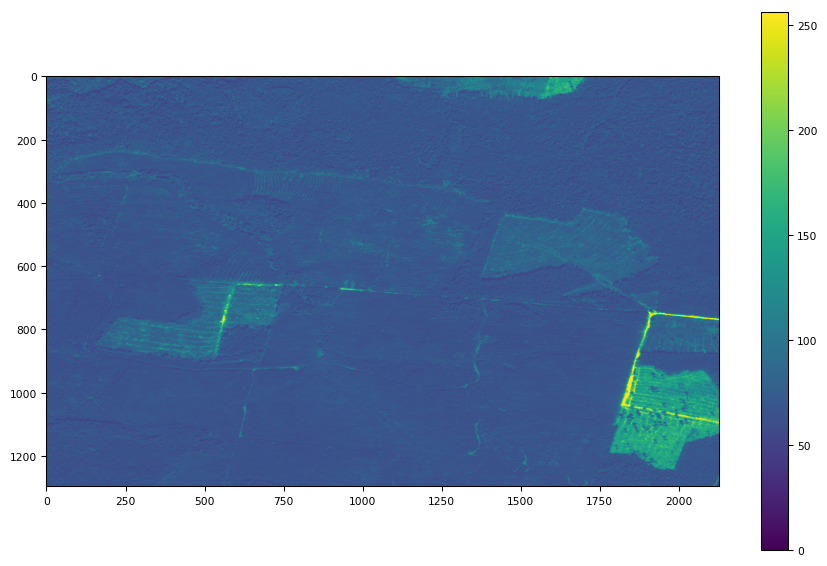

In [31]:
tmp = tiff.imread('/home/user/data/krasnoborsk/world_view/4/3_2_channel_0.tif')
tiff.imshow(tmp)

In [35]:
pred, mask = generator.pred_img(model=model, img_path=generator.train_img_list[8])
    

In [41]:
mask.shape, mask[:,:,0].shape, cl_0[:,:,0].shape

((2498, 1918, 4), (2498, 1918), (2498, 1918))

In [46]:
for cl in range(4):
    pred[:,:,cl] = np.where(np.argmax(pred, axis=-1)==cl, 1, 0)

In [42]:
cl_0 = np.zeros((mask.shape[0], mask.shape[1], 3))

cl_0[:,:,0] = mask[:,:,0]*0.267004
cl_0[:,:,1] = mask[:,:,0]*0.004874
cl_0[:,:,2] = mask[:,:,0]*0.329415

cl_1 = np.zeros((mask.shape[0], mask.shape[1], 3))

cl_1[:,:,0] = mask[:,:,1]*0.190631
cl_1[:,:,1] = mask[:,:,1]* 0.407061
cl_1[:,:,2] = mask[:,:,1]* 0.556089

cl_2 = np.zeros((mask.shape[0], mask.shape[1], 3))

cl_2[:,:,0] = mask[:,:,2]*0.20803
cl_2[:,:,1] = mask[:,:,2]* 0.718701
cl_2[:,:,2] = mask[:,:,2]* 0.472873

cl_3 = np.zeros((mask.shape[0], mask.shape[1], 3))

cl_3[:,:,0] = mask[:,:,3]*0.993248
cl_3[:,:,1] = mask[:,:,3]* 0.906157
cl_3[:,:,2] = mask[:,:,3]* 0.143936

In [47]:
pr_0 = np.zeros((pred.shape[0], pred.shape[1], 3))

pr_0[:,:,0] = pred[:,:,0]*0.267004
pr_0[:,:,1] = pred[:,:,0]*0.004874
pr_0[:,:,2] = pred[:,:,0]*0.329415

pr_1 = np.zeros((pred.shape[0], pred.shape[1], 3))

pr_1[:,:,0] = pred[:,:,1]*0.190631
pr_1[:,:,1] = pred[:,:,1]* 0.407061
pr_1[:,:,2] = pred[:,:,1]* 0.556089

pr_2 = np.zeros((pred.shape[0], pred.shape[1], 3))

pr_2[:,:,0] = pred[:,:,2]*0.20803
pr_2[:,:,1] = pred[:,:,2]* 0.718701
pr_2[:,:,2] = pred[:,:,2]* 0.472873

pr_3 = np.zeros((pred.shape[0], pred.shape[1], 3))

pr_3[:,:,0] = pred[:,:,3]*0.993248
pr_3[:,:,1] = pred[:,:,3]* 0.906157
pr_3[:,:,2] = pred[:,:,3]* 0.143936

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f8374f5c4e0>)

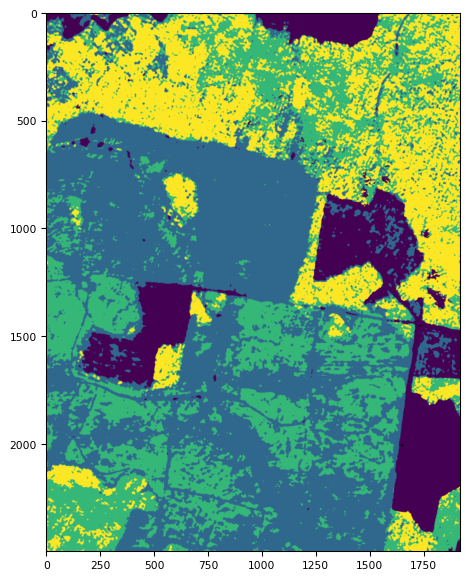

In [48]:
tiff.imshow((pr_0 + pr_1+pr_2+pr_3)*np.where(cl_0 + cl_1+cl_2+cl_3!=0, 1, 0))

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f8374f87128>)

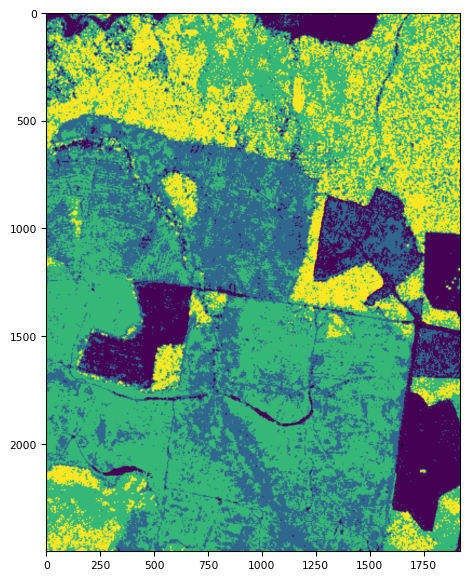

In [45]:
tiff.imshow((cl_0 + cl_1+cl_2+cl_3))

# This part is from another notebook

## Save predictions

In [105]:
predicted_4cl, forestarr = generate_nir_new(model)

In [106]:
def save_pred(nir_img, dse_ind, cl_id='0'):    
   
    a = np.reshape(nir_img, (nir_img.shape[0], nir_img.shape[1]))
    #ret = str(subprocess.check_output("gdalinfo {}_channel_0.tif".format(dse_ind), shell=True))
    #imgpath[:-3] + 'height_' + imgpath.split('/')[-1]
    ret = str(subprocess.check_output("gdalinfo {}height_{}.tif".format(dse_ind[:-3], dse_ind.split('/')[-1]), shell=True))
    
    n = ret.find('Pixel Size')+len('Pixel Size = (')
    dx = float(ret[n:n+ret[n:].find(',')])
    dy = float(ret[1+n+ret[n:].find(','):n+ret[n:].find(')')])

    n = ret.find('Origin = (') + len('Origin = (')
    x0 = float(ret[n:n+ret[n:].find(',')])
    y0 = float(ret[1+n+ret[n:].find(','):n+ret[n:].find(')')])

    n = ret.find('Size is ')+len('Size is ')
    size_x = int(ret[n:n+ret[n:].find(',')])
    size_y = int(ret[2+n+ret[n:].find(','):n+ret[n:].find('\\')])
    
    nx = int(size_x) 
    ny = int(size_y)

    x1 = x0 + size_x*dx
    y1 = y0 + (size_y) * dy

    xmin, ymin, xmax, ymax = x0, y1, x1, y0 

    xres = dx
    yres = -dy
    geotransform = (xmin, xres, 0, ymax, 0, -yres)

    #dst_ds = gdal.GetDriverByName('GTiff').Create('/home/user/data/krasnoborsk/pred/{}_{}.tif'.format(dse_ind[-3:], cl_id),  nx, ny, 1, gdal.GDT_Byte)
    dst_ds = gdal.GetDriverByName('GTiff').Create('/home/user/data/krasnoborsk/pred/regr_{}.tif'.format(dse_ind[-3:]),  nx, ny, 1, gdal.GDT_Byte)
   
    '''
    mean = np.mean(a)
    std = np.std(a)
    m = max(a.min(), mean - 3*std) # a.min() --> 0
    M = min(a.max(), mean + 3*std)
    a = ((a - m)*255.0/(M-m)).clip(1, 255).astype(np.uint8)
    '''
    a = (a*30).astype(np.uint8)
    dst_ds.SetGeoTransform(geotransform)    # specify coords
    srs = osr.SpatialReference()            # establish encoding
    srs.ImportFromEPSG(4326) #3857)                #  32639 WGS84 lat/long
    dst_ds.SetProjection(srs.ExportToWkt()) # export coords to file
    dst_ds.GetRasterBand(1).WriteArray(a)   # write r-band to the raster
    dst_ds.FlushCache()                     # write to disk
    dst_ds = None
    

In [107]:
import subprocess
from osgeo import gdal
from osgeo import osr
from os import listdir
from pyproj import Proj, transform
      
for dse_ind in range(len(val_img_list)):
    save_pred(predicted_4cl[dse_ind],val_img_list[dse_ind])

In [46]:
from aeronet.dataset import polygonize, BandCollection, FeatureCollection, parse_directory

In [ ]:
DIR = '/home/user/data/krasnoborsk/pred'
for dse_ind in range(len(val_img_list)):
    for i, cl_id in enumerate(['cl0', 'cl1', 'cl2', 'cl3']):
        file_name = val_img_list[dse_ind][-3:] + '_' + cl_id
        mask = BandCollection(parse_directory(DIR, [file_name]))
        vector = polygonize(mask[0], properties={'height': 'cl2'})
        vector.save('/home/user/data/krasnoborsk/pred/{}_{}.geojson'.format(val_img_list[dse_ind][-3:], cl_id))



In [108]:
def metric2tif(model, num_cl = 4, div_koef=5):
    
    pred=[]
    maskarr=[]
    for id_elem in range(len(val_img_list)):
        imgpath = val_img_list[id_elem]
        with rasterio.open(imgpath[:-3] + 'height_' + imgpath.split('/')[-1] +'.tif') as src:
            size_y = src.width #x y
            size_x = src.height
        dim = (size_x, size_y)
        mask = np.zeros((size_x// div_koef, size_y// div_koef, num_cl)) 
        with rasterio.open(imgpath[:-3] + 'height_' + imgpath.split('/')[-1] +'.tif') as src:
            mask_0 = src.read(1).astype(np.float)
            mask_0 = cv2.resize(mask_0, (size_y // div_koef, size_x // div_koef), interpolation=cv2.INTER_AREA)
        
        #class_606 = np.zeros((img.shape[0], img.shape[1], 1)) 
        with rasterio.open(imgpath+ '_class_606.tif') as src:
            mask_606 = src.read(1)
            mask_606 = cv2.resize(mask_606, (size_y// div_koef, size_x// div_koef), interpolation=cv2.INTER_NEAREST)

        #---------------------------------------------------------------------------------------
        # clean data
        #---------------------------------------------------------------------------------------
        felling = np.where(mask_0 < 1., 1, 0) * mask_606
        cloud = np.where(mask_0 > 5., 1, 0) * np.where(mask_606>0, 0, 1)
        mask_0 *= np.where(felling==1, 0, 1) * np.where(cloud==1, 0, 1)
        
        #print(dim)
        #print(mask.shape, mask_0.shape)
        mask[:,:,0] = np.where(mask_0>0, 1, 0)*np.where(mask_0<=4, 1, 0)
        mask[:,:,1] = np.where(mask_0>4, 1, 0)*np.where(mask_0<=10, 1, 0)
        mask[:,:,2] = np.where(mask_0>10, 1, 0)*np.where(mask_0<=20, 1, 0)
        mask[:,:,3] = np.where(mask_0>20, 1, 0)
        
        
        #element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        #erosion = cv2.erode(mask[:,:,1], element, iterations = 1)
        #mask[:,:,1] = cv2.dilate(erosion, element, iterations = 1)
        
        #return mask
        pred_tmp = np.zeros((size_x// div_koef, size_y// div_koef, num_cl), dtype=int) 
        with rasterio.open('/home/user/data/krasnoborsk/pred/regr_{}.tif'.format(imgpath.split('/')[-1])) as src:
            mask_0 = src.read(1)
            mask_0 = cv2.resize(mask_0, (size_y // div_koef, size_x // div_koef), interpolation=cv2.INTER_AREA)
        pred_tmp[:,:,0] = np.where(mask_0>=0, 1, 0)*np.where(mask_0<=4, 1, 0) 
        pred_tmp[:,:,1] = np.where(mask_0>4, 1, 0)*np.where(mask_0<=10, 1, 0)
        pred_tmp[:,:,2] = np.where(mask_0>10, 1, 0)*np.where(mask_0<=18, 1, 0)
        pred_tmp[:,:,3] = np.where(mask_0>18, 1, 0)
        #for i in range(num_cl):
        #    with rasterio.open('/home/user/data/krasnoborsk/pred/{}_cl{}.tif'.format(imgpath.split('/')[-1], i)) as src:
        #        pred_tmp[:,:,i] = src.read(1)
        #        pred_tmp[:,:,i] = np.where(pred_tmp[:,:,i]>0, 1, 0)
        
        #tiff.imshow(mask[:,:,0])
        #tiff.imshow(pred_tmp[:,:,0])
        #return
        pred.append(pred_tmp)
        maskarr.append(mask)
        #return(pred, maskarr)
    maskarr = np.asarray(maskarr) 
    pred = np.asarray(pred) 
    
    precision = np.zeros((num_cl))
    recall = np.zeros((num_cl))
    f1_cl = np.zeros((num_cl))
  
    for cl in range(num_cl):
        recall[cl] = np.sum(maskarr[:,:,:,cl]*np.where(pred[:,:,:,cl]==1, 1, 0)) / np.sum(maskarr[:,:,:,cl])
        precision[cl] = np.sum(maskarr[:,:,:,cl]*np.where(pred[:,:,:,cl]==1, 1, 0)) / np.sum(np.sum(maskarr, axis=-1)*np.where(pred[:,:,:,cl]==1, 1, 0))

    f1_cl = 2*((precision*recall)/(precision+recall))

    classes = ['0', '1', '2','4' ]
    for i in range(num_cl):
        print(classes[i], ': precision ', round(precision[i], 5), ' recall ', round(recall[i], 5), ' f1 ', round(f1_cl[i], 5))
        print(' ')